In [1]:
cellpose_seg0 = r"output\test\2D_patch_test_0_seg.npy"
cellpose_seg1 = r"output\test\2D_patch_test_1_seg.npy"


In [119]:
import numpy as np
from cellpose import plot, utils, io, models
import matplotlib.pyplot as plt
from skimage.draw import polygon

# Load the segmentation mask
dat_0 = np.load(cellpose_seg0, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_0 = dat_0['masks']
outlines_0 = utils.outlines_list(masks_0) # multiprocessing_threshold=1000



Multiprocessing is disabled for Windows


In [120]:
# Create a blank binary image to fill in the cells
filled_image_0 = np.zeros_like(masks_0, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_0:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_0.shape)
    filled_image_0[rr, cc] = 255  # Fill with white (255) inside each contour

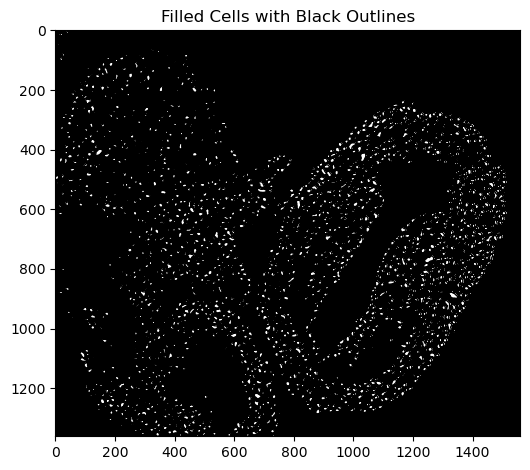

In [121]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_0, cmap='gray', interpolation='none')
for outline in outlines_0:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth   =1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [122]:
# Load the segmentation mask
dat_1 = np.load(cellpose_seg1, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_1 = dat_1['masks']
outlines_1 = utils.outlines_list(masks_1) # multiprocessing_threshold=1000

Multiprocessing is disabled for Windows


In [123]:
# Create a blank binary image to fill in the cells
filled_image_1 = np.zeros_like(masks_1, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_1:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_1.shape)
    filled_image_1[rr, cc] = 255  # Fill with white (255) inside each contour

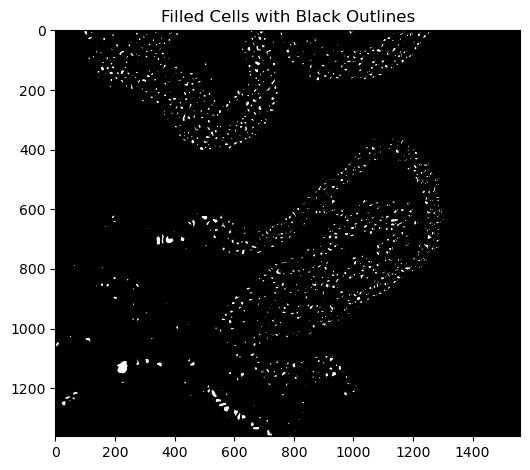

In [124]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_1, cmap='gray', interpolation='none')
for outline in outlines_1:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth=1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [172]:
# Define the shape of the new mask
mask_shape = (2478, 1560)

# Create a zero-filled mask
filled_image_new = np.zeros(mask_shape, dtype=np.uint8) 

# Define adjusted main segment coordinates
segments = [
    (0, 1362, 0, 1560),   # Segment 0
    (1116, 2478, 0, 1560) # Segment 1
]

# Offsets for each segment
offsets = [
    (0, 0),               # No offset for Segment 0
    (1116, 0)             # Offset for Segment 1 (row offset, column offset)
]

# New outline list
new_outlines = []

# Fill each outline's interior as white
for outline in outlines_0:
    # Add [1116, 0] to each coordinate in the outline
    outline = np.array(outline, dtype=np.int32) + np.array([0, 0], dtype=np.int32)
    new_outlines.append(outline)

    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 155  # Fill with white (255) inside each contour

# Fill each outline's interior as white
for outline in outlines_1:
    # Add [1116, 0] to each coordinate in the outline
    outline = np.array(outline, dtype=np.int32) + np.array([0, 1116], dtype=np.int32)
    new_outlines.append(outline)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour

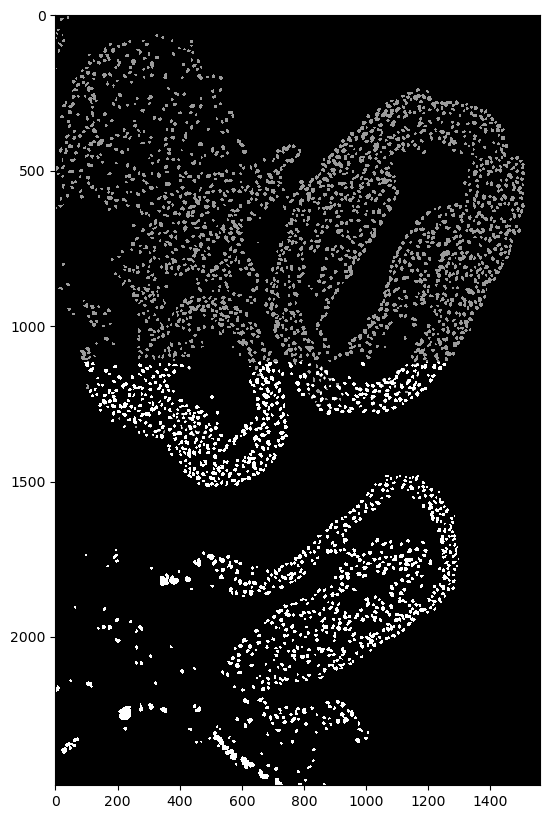

In [173]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(filled_image_new, cmap='gray', interpolation='none')

In [175]:
def calculate_overlap(segments):
    """
    Calculates the overlap region of segmentation and returns the coordinates.

    Parameters:
        segments (list of tuples): List of segment boundaries in the form
                                   (y_start, y_end, x_start, x_end).

    Returns:
        tuple: Overlap region as (y_start, y_end, x_start, x_end), or None if no overlap exists.
    """
    if len(segments) < 2:
        raise ValueError("At least two segments are required to calculate overlap.")

    # Extract boundaries for the two segments
    y_start1, y_end1, x_start1, x_end1 = segments[0]
    y_start2, y_end2, x_start2, x_end2 = segments[1]

    # Calculate overlap boundaries
    y_start_overlap = max(y_start1, y_start2)
    y_end_overlap = min(y_end1, y_end2)
    x_start_overlap = max(x_start1, x_start2)
    x_end_overlap = min(x_end1, x_end2)

    # Check if there is an actual overlap
    if y_start_overlap < y_end_overlap and x_start_overlap < x_end_overlap:
        return (y_start_overlap, y_end_overlap, x_start_overlap, x_end_overlap)
    else:
        return None  # No overlap exists


In [176]:
# Define segment boundaries
segments = [
    (0, 1362, 0, 1560),   # Segment 0
    (1116, 2478, 0, 1560) # Segment 1
]

# Calculate the overlap region
overlap_region = calculate_overlap(segments)

if overlap_region:
    print(f"Overlap region coordinates: {overlap_region}")
else:
    print("No overlap exists.")


Overlap region coordinates: (1116, 1362, 0, 1560)


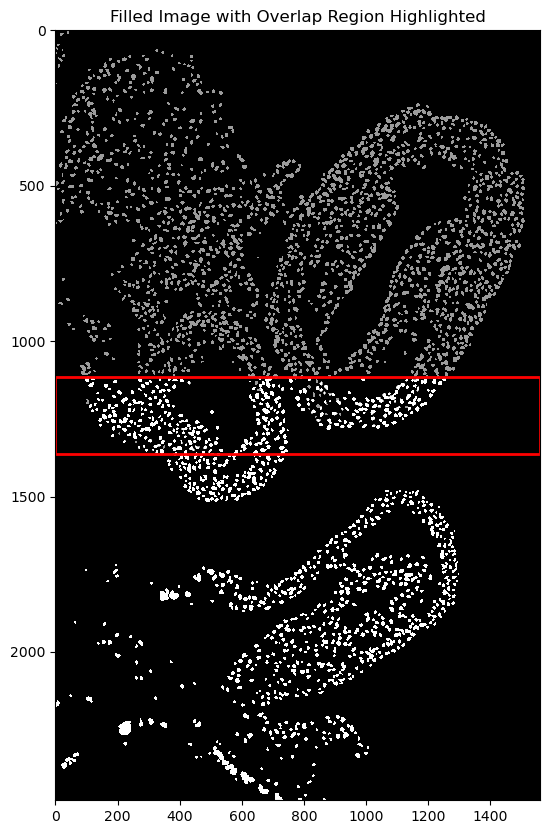

In [177]:
import matplotlib.patches as patches

# Plot the filled binary image with the overlap rectangle
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(filled_image_new, cmap='gray', interpolation='none')

if overlap_region:
    y_start, y_end, x_start, x_end = overlap_region
    # Draw the overlap rectangle
    rect = patches.Rectangle(
        (x_start, y_start),  # Bottom-left corner
        x_end - x_start,     # Width
        y_end - y_start,     # Height
        linewidth=2,
        edgecolor='red',
        facecolor='none'     # Transparent fill
    )
    ax.add_patch(rect)

# Add labels and display the figure
ax.set_title("Filled Image with Overlap Region Highlighted")
plt.show()


In [178]:
import pandas as pd

def boundaries_to_table(boundaries):
    # Create an empty list to store data rows
    data = []
    
    # Loop through each boundary (each cell)
    for cell_id, boundary in enumerate(boundaries, start=1):
        # Loop through each point in the boundary
        for point in boundary:
            # Append cell_id, x, y to the data list
            data.append([cell_id, point[0], point[1]])
    
    # Create a DataFrame with the data
    df = pd.DataFrame(data, columns=['cell_id', 'vertex_x', 'vertex_y'])
    
    return df

In [184]:
# Convert boundaries to table
df_outlines_list_0 = boundaries_to_table(outlines_0)
df_outlines_list_0

,cell_id,vertex_x,vertex_y
0,1,40,3
1,1,39,4
2,1,38,5
3,1,37,6
4,1,37,7
...,...,...,...
67291,2035,457,1359
67292,2035,456,1359
67293,2035,455,1359
67294,2035,454,1359


In [185]:
# Convert boundaries to table
df_outlines_list_1 = boundaries_to_table(outlines_1)
df_outlines_list_1

,cell_id,vertex_x,vertex_y
0,1,93,0
1,1,93,1
2,1,94,2
3,1,95,3
4,1,95,4
...,...,...,...
36174,1087,869,1359
36175,1087,868,1358
36176,1087,867,1357
36177,1087,866,1356


In [186]:
def reduce_points(df):
    # Group by cell_id and get counts
    cell_counts = df.groupby('cell_id').size()
    
    new_df = pd.DataFrame()
    
    for cell_id in cell_counts.index:
        cell_data = df[df['cell_id'] == cell_id]
        
        if cell_counts[cell_id] > 50:
            # Keep every other row until we have 50 points
            reduced_data = cell_data.iloc[::2].head(50)
        elif 30 < cell_counts[cell_id] <= 50:
            # Keep every other row until we have 30 points
            reduced_data = cell_data.iloc[::2].head(30)
        else:
            # Keep all points if count <= 30
            reduced_data = cell_data
            
        new_df = pd.concat([new_df, reduced_data])
    
    return new_df.reset_index(drop=True)

In [187]:
# Apply the function
reduced_outlines_list_0 = reduce_points(df_outlines_list_0)
reduced_outlines_list_1 = reduce_points(df_outlines_list_1)

# Print the results
print("Original shape 0:", df_outlines_list_0.shape)
print("Reduced shape 0:", reduced_outlines_list_0.shape)

# Print the results
print("Original shape 1:", df_outlines_list_1.shape)
print("Reduced shape 1:", reduced_outlines_list_1.shape)

Original shape 0: (67296, 3)
Reduced shape 0: (44856, 3)
Original shape 1: (36179, 3)
Reduced shape 1: (24213, 3)


In [188]:
# Process to append the first row of each cell group
Outlines_list_final_0 = (
    reduced_outlines_list_0.groupby('cell_id', group_keys=False)
    .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
)

# Process to append the first row of each cell group
Outlines_list_final_1 = (
    reduced_outlines_list_1.groupby('cell_id', group_keys=False)
    .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
)


C:\Users\Alexis\AppData\Local\Temp\ipykernel_131992\2773137253.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
C:\Users\Alexis\AppData\Local\Temp\ipykernel_131992\2773137253.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))


In [190]:
unique_cell_count = Outlines_list_final_0['cell_id'].nunique()
# unique_cell_count = boundary_df['cell_id'].nunique()

unique_cell_count

2035

In [137]:

def calculate_centroids(df):
    # Group the DataFrame by 'cell_id'
    grouped = df.groupby('cell_id')
    
    # Calculate centroids for each group
    centroids = grouped[['vertex_x', 'vertex_y']].mean().reset_index()
    
    # Rename columns if needed to indicate centroids explicitly
    centroids.rename(columns={'vertex_x': 'centroid_x', 'vertex_y': 'centroid_y'}, inplace=True)
    
    return centroids


In [192]:
# Calculate centroids for each cell
centroids_df_0 = calculate_centroids(Outlines_list_final_0)
centroids_df_0

,cell_id,centroid_x,centroid_y
0,1,41.280000,7.080000
1,2,21.000000,12.724138
2,3,9.904762,46.857143
3,4,4.869565,58.391304
4,5,327.423077,65.461538
...,...,...,...
2030,2031,419.451613,1357.290323
2031,2032,645.250000,1357.550000
2032,2033,476.285714,1358.000000
2033,2034,731.379310,1358.344828


In [194]:
# Calculate centroids for each cell
centroids_df_1 = calculate_centroids(Outlines_list_final_1)
centroids_df_1

,cell_id,centroid_x,centroid_y
0,1,102.000000,6.413793
1,2,657.764706,3.117647
2,3,690.571429,5.857143
3,4,709.296296,1.629630
4,5,756.869565,9.043478
...,...,...,...
1082,1083,673.257143,1334.114286
1083,1084,717.825000,1351.550000
1084,1085,805.000000,1345.826087
1085,1086,788.176471,1357.941176


In [195]:
overlap_region

(1116, 1362, 0, 1560)

In [197]:
import pandas as pd

def filter_centroids_in_overlap(centroid_df, overlap_region):
    """
    Filters centroids within a specified overlap region.

    Parameters:
        centroid_df (pd.DataFrame): DataFrame with columns 'cell_id', 'centroid_x', 'centroid_y'.
        overlap_region (tuple): Overlap region defined as (y_start, y_end, x_start, x_end).

    Returns:
        pd.DataFrame: Subset of the input DataFrame with centroids in the overlap region.
    """
    y_start, y_end, x_start, x_end = overlap_region

    # Filter the DataFrame for centroids within the overlap region
    filtered_df = centroid_df[
        (centroid_df['centroid_y'] >= y_start) &
        (centroid_df['centroid_y'] <= y_end) &
        (centroid_df['centroid_x'] >= x_start) &
        (centroid_df['centroid_x'] <= x_end)
    ]

    return filtered_df




In [198]:


# Call the function
sub_dataframe_0 = filter_centroids_in_overlap(centroids_df_0, overlap_region)

# Display the result
sub_dataframe_0

,cell_id,centroid_x,centroid_y
1701,1702,103.583333,1123.041667
1702,1703,658.103448,1119.172414
1703,1704,690.904762,1121.761905
1704,1705,756.280000,1124.760000
1705,1706,990.263158,1122.157895
...,...,...,...
2030,2031,419.451613,1357.290323
2031,2032,645.250000,1357.550000
2032,2033,476.285714,1358.000000
2033,2034,731.379310,1358.344828


In [201]:
# Call the function
sub_dataframe_1 = filter_centroids_in_overlap(centroids_df_1, overlap_region)

# Display the result
sub_dataframe_1

,cell_id,centroid_x,centroid_y
1001,1002,220.019608,1134.098039
1005,1006,460.551724,1119.000000
1007,1008,349.935484,1119.548387
1008,1009,778.681818,1117.454545
1009,1010,722.117647,1118.176471
...,...,...,...
1082,1083,673.257143,1334.114286
1083,1084,717.825000,1351.550000
1084,1085,805.000000,1345.826087
1085,1086,788.176471,1357.941176


In [202]:
def filter_outlines_by_cell_ids(outlines_df, sub_dataframe):

    # Get the set of cell_ids from the sub_centroid_df
    cell_ids_to_keep = set(sub_dataframe['cell_id'])
    
    # Filter the outlines_df to include only rows with cell_id in the set
    filtered_outlines_df = outlines_df[outlines_df['cell_id'].isin(cell_ids_to_keep)]
    
    return filtered_outlines_df


In [204]:
# Call the function to filter outlines
filtered_outlines_df_0 = filter_outlines_by_cell_ids(Outlines_list_final_0, sub_dataframe_0)

# Display the filtered outlines
filtered_outlines_df_0

,cell_id,vertex_x,vertex_y
0,1702,104,1114
1,1702,102,1115
2,1702,100,1117
3,1702,98,1118
4,1702,97,1120
...,...,...,...
15,2035,456,1359
16,2035,455,1359
17,2035,454,1359
18,2035,453,1359


In [205]:
# Call the function to filter outlines
filtered_outlines_df_1 = filter_outlines_by_cell_ids(Outlines_list_final_1, sub_dataframe_1)

# Display the filtered outlines
filtered_outlines_df_1

,cell_id,vertex_x,vertex_y
0,1002,228,1107
1,1002,226,1108
2,1002,224,1108
3,1002,223,1110
4,1002,221,1111
...,...,...,...
18,1087,868,1358
19,1087,867,1357
20,1087,866,1356
21,1087,865,1356


In [206]:
import numpy as np

def dataframe_to_outline_list(filtered_outlines):

    outline_list = []
    
    # Group by 'cell_id' and extract vertices for each cell
    grouped = filtered_outlines.groupby('cell_id')
    for _, group in grouped:
        # Extract (vertex_x, vertex_y) as a NumPy array
        outline = group[['vertex_x', 'vertex_y']].to_numpy(dtype=np.int32)
        outline_list.append(outline)
    
    return outline_list


In [207]:
overlap_outline_list_0 = dataframe_to_outline_list(filtered_outlines_df_0)

In [208]:
overlap_outline_list_1 = dataframe_to_outline_list(filtered_outlines_df_1)

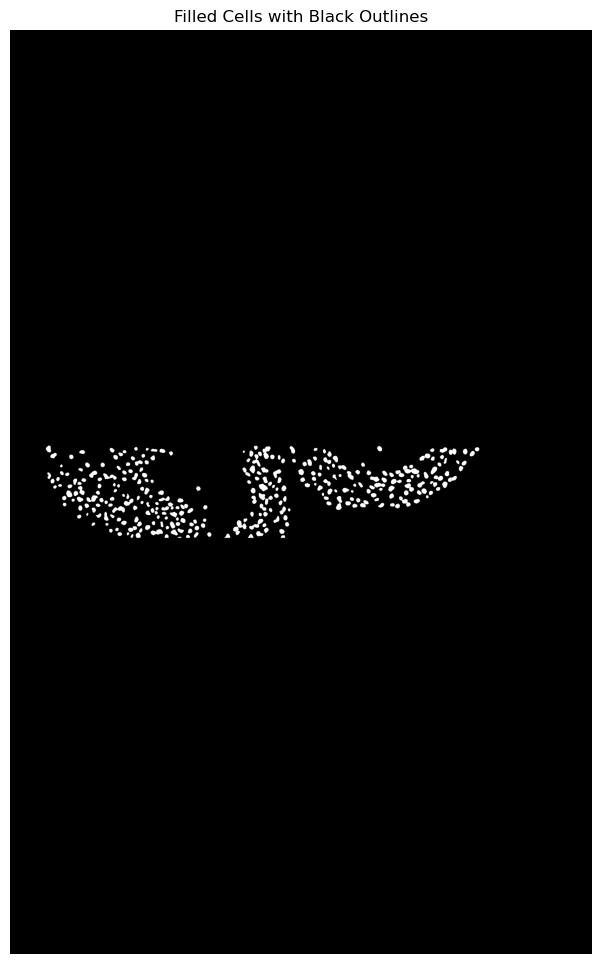

In [216]:
# Iterate over polygons and assign each one a unique label
# Create a blank canvas (e.g., 800x800)
from shapely.geometry import Polygon
from skimage.draw import polygon 


image_array = np.zeros((2478, 1560), dtype=np.uint8)

# Draw black outlines on top of the filled areas
for outline in overlap_outline_list_0:
    outline = np.array(outline, dtype=np.int32)
    rr, cc = polygon(outline[:, 1], outline[:, 0], image_array.shape)
    image_array[rr, cc] = 255  # Fill with white (255) inside each contour

# Save the result as a variable
image_array_0 = image_array

# Display the final image
plt.figure(figsize=(12, 12))
plt.imshow(image_array_0, cmap='gray')
plt.title("Filled Cells with Black Outlines")
plt.axis('off')
plt.show()




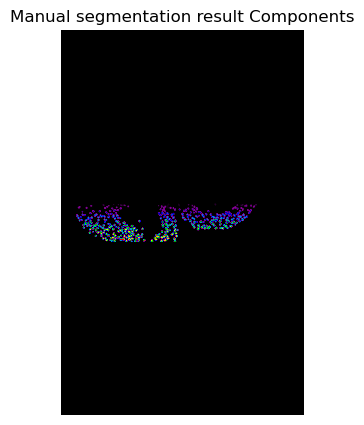

In [217]:
import cv2
# Apply connected components to label the connected regions
# It returns two values:
# num_labels: number of labels (including background)
# labels: image array where each connected component has a unique label
num_labels, labels_im = cv2.connectedComponents(image_array_0)

# Visualize the result using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(labels_im, cmap='nipy_spectral')
plt.title('Manual segmentation result Components')
plt.axis('off')
plt.show()


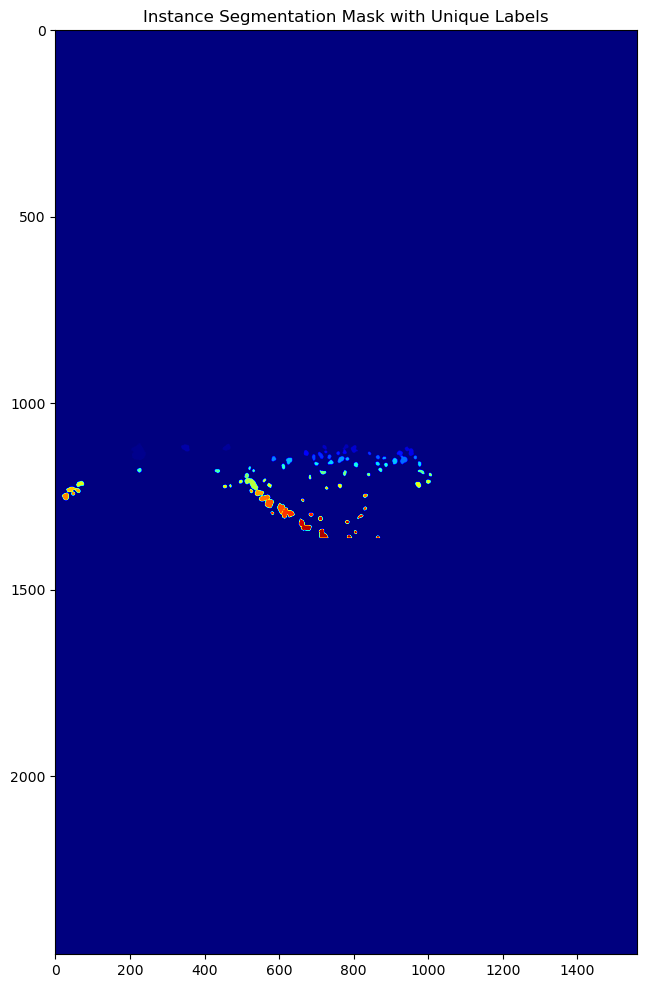

In [211]:
# Iterate over polygons and assign each one a unique label
# Create a blank canvas (e.g., 800x800)
from shapely.geometry import Polygon
from skimage.draw import polygon 
image_array = np.zeros((2478, 1560), dtype=np.uint8)


for label, poly_coords in enumerate(overlap_outline_list_1, start=1):
    # Create a Shapely polygon from the coordinates
    polygon_obj = Polygon(poly_coords)

    # Extract x and y coordinates for drawing
    x_coords, y_coords = poly_coords[:, 0], poly_coords[:, 1]

    # Convert polygon coordinates to pixel coordinates and rasterize
    rr, cc = polygon(y_coords, x_coords, shape=image_array.shape)

    # Assign the unique label to the instance in the image (label 1, 2, 3, ...)
    image_array[rr, cc] = label

# Visualize the result
plt.figure(figsize=(12, 12))
plt.imshow(image_array, cmap='jet')
plt.title('Instance Segmentation Mask with Unique Labels')
plt.axis('on')
plt.show()


In [159]:
# cell_groups = pd.DataFrame(cell_groups)
# cell_groups

In [222]:
import numpy as np
import pandas as pd
import cv2
from shapely.geometry import Polygon
from skimage.draw import polygon

def calculate_iou(ground_truth_mask, test_mask):
    # Calculate intersection and union
    intersection = np.logical_and(ground_truth_mask, test_mask)
    union = np.logical_or(ground_truth_mask, test_mask)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou


ious = []


iou_threshold = 0.4
matched_test_instances = set()  # To track test instances that have been matched

comparison_data = []

# Loop over each instance in the ground truth
for label in range(1, num_labels):  # num_labels from connectedComponents
    # Create a binary mask for the current label (instance) in the ground truth
    ground_truth_mask = (labels_im == label).astype(np.uint8)
    
    best_iou = 0  # Track the best IoU for the current ground truth instance
    best_test_label = None  # Track which test label gives the best IoU
    
    print(f"\nProcessing ground truth instance {label}...")
    
    # !!   scaled_all_polygons
    # Loop over the test set polygons (each one is already labeled in your test set)
    for test_label, poly_coords in enumerate(overlap_outline_list_1, start=1):
        if test_label in matched_test_instances:
            # Skip this test instance if it has already been matched
            continue
        
        # Create binary mask for the current test set polygon (instance)
        test_mask = np.zeros_like(ground_truth_mask)
        x_coords, y_coords = poly_coords[:, 0], poly_coords[:, 1]
        rr, cc = polygon(y_coords, x_coords, shape=test_mask.shape)
        test_mask[rr, cc] = 1
        
        # Calculate IoU between the current ground truth instance and test set instance
        iou = calculate_iou(ground_truth_mask, test_mask)
        # # Print IoU to monitor progress
        # print(f"  IoU between ground truth {label} and test {test_label}: {iou:.4f}")
        
        # If IoU is above the threshold and better than the current best, record it
        if iou > iou_threshold and iou > best_iou:
            best_iou = iou
            best_test_label = test_label

    # If we found a match (IoU > 0.40), append it to the list
    if best_test_label is not None:
        print(f"  Best match for ground truth {label} is test {best_test_label} with IoU {best_iou:.4f}")
        matched_test_instances.add(best_test_label)
        ious.append(best_iou)


        # Append the comparison data
        comparison_data.append({
            'Ground Truth Instance': label,
            'Cellpose Segmentation Instance': best_test_label,
            'IoU': best_iou,

        })
        
    else:
        print(f"  No match found for ground truth {label} (IoU > {iou_threshold})")

# Save the DataFrame to a CSV file
comparison_df = pd.DataFrame(comparison_data)

# Display the first few rows of the DataFrame
print(comparison_df.head())

# Calculate mean IoU if we have any matches
if ious:
    mean_iou = np.mean(ious)

    print(f"\nMean IoU: {mean_iou:.4f}")

else:
    print("\nNo matched instances found with IoU > 0.40")




Processing ground truth instance 1...
  No match found for ground truth 1 (IoU > 0.4)

Processing ground truth instance 2...
  No match found for ground truth 2 (IoU > 0.4)

Processing ground truth instance 3...
  No match found for ground truth 3 (IoU > 0.4)

Processing ground truth instance 4...
  No match found for ground truth 4 (IoU > 0.4)

Processing ground truth instance 5...
  No match found for ground truth 5 (IoU > 0.4)

Processing ground truth instance 6...
  No match found for ground truth 6 (IoU > 0.4)

Processing ground truth instance 7...
  No match found for ground truth 7 (IoU > 0.4)

Processing ground truth instance 8...
  No match found for ground truth 8 (IoU > 0.4)

Processing ground truth instance 9...
  No match found for ground truth 9 (IoU > 0.4)

Processing ground truth instance 10...
  No match found for ground truth 10 (IoU > 0.4)

Processing ground truth instance 11...
  No match found for ground truth 11 (IoU > 0.4)

Processing ground truth instance 12...

In [223]:
comparison_df

,Ground Truth Instance,Cellpose Segmentation Instance,IoU
0,232,73,0.586466


In [ ]:

comparison_df.to_csv('result/comparison_df_1835OD_HIL.csv', index=False)
